# Analysis of participant choices, reinforcement learning scores and questionnaire data

 Supplementary material of the article 

*The Role of Sensorimotor Contingencies and Eye Scanpath Entropy in Presence in Virtual Reality: A Reinforcement Learning Paradigm*

by Esen Küçüktütüncü, Francisco Macia-Varela, Joan Llobera, and Mel Slater



 
It contains the scripts to run part of the data analysis reported in this article, as well as the raw data needed to do so.
This notebook is organized in different sections:

0. **Setup** We import dependencies and visualization scripts.
1. **Data parsing**
This section contains the data parser. It also imports the data files.
2. **Participant choices**
This section parses the RL data to estimate the preferred configurations of the users.

3. **Demographic data** 

4. **Formatting for Statistical data analysis**
The participant choices are formated to prepare the statistical data analysis (programmed using R using a different notebook)





In [1]:

#################################################
# Dependencies
#################################################

#To run it locally, check the readme



# To run in Kaggle:

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory




import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

#################################################
# Configuration
#################################################

#in kaggle:
#datapath= '/kaggle/input/presence-rl-text'

#in a local notebook:
datapath= './rawdata/'


#to write intermediary files:
WRITE_DATA = False


# to remove stored intermediary files, 
# the instructions below will give an error but remove everything in the output folder
#import shutil
#shutil.rmtree("/kaggle/working/")


In [2]:
#general dependencies
import pandas as pd
import numpy as np


import seaborn as sb
import matplotlib.pyplot as plt
png_res = 300


import re
import openpyxl


#import pdb; #this is for the debugger
from openpyxl import load_workbook

from collections import Counter 


from scipy import stats

if WRITE_DATA:
    from openpyxl import load_workbook


## 1. Data parsing 

This section load the functions for data parsing and formatting of the labels. The data parser works iteratively. It gets the data of all participants, one by one, and stores it in the format:

     data[participant_num][iteration][dictionary_key]
     

We introduce some functions useful for all the matrices that we will calculate.

In [3]:
selectedParticipants = ['101','102', '103', '104', '105','106','108', '109', '110', '111','112','113','114','115','116','117','118','119','120','121','122','124','126','127', '128','129']

#last_iteration = 10
last_iterations = (15,14,16,15,13,10,23,10,10,20,10,23,16,23,21,13,21,22,21,20,14,18,15,12,19,19)

#to check with half the iterations:
#last_iteration = 12

participant_data = []


#support function used to parse a matrix: 
def _parse_matrix(matstring):
    vals = []
    for val in matstring.split(', '):#important to have a space
        val = val.strip() #to remove additional spaces
        val = val.replace(',','.') #decimals marked with points
        val = val.strip()
        if(len(val)>0):
            #print(val)
            vals.append(float(val))
    return vals


for participant_idx, x in enumerate(selectedParticipants):
    filename = datapath + '/rldata_' +x+'.txt'
    #print(filename)
    one_participant_data = []
    
    with open(filename) as file:
        
        file_contents = file.read()
        #print(file_contents)
        rest = file_contents
        i = 0
        last_iteration = last_iterations[participant_idx]
        while(i < last_iteration):
            data_dict = {}


            temp1 = rest.split('\n',1);
            infoline = temp1[0];
            rest = temp1[1];

            #up to next semicolon it is a matrix (3 times)
            temp2 = rest.split(';',3)

            infoQmat = temp2[0]
            infoPresentations = temp2[1]
            infoAccepted = temp2[2]
            rest = temp2[3]
            #print("the length left is: " + str(len(rest)))

            #we take care of the infoline:
            vals = []
            for val in  infoline.split(';'):
                vals.append(val);

            #pdb.set_trace()
            #print(vals)
            #print("length of vals is: " + str(len(vals)));
            data_dict['participantID'] = vals[0];
            data_dict['datetime'] = (vals[1]);
            data_dict['secsstarted'] = vals[2];
            data_dict['currentstate'] = str(vals[3]);

            #we also take care of the matrices:
            data_dict['infoQmat'] = _parse_matrix(infoQmat);
            data_dict['infoPres'] = _parse_matrix(infoPresentations);
            data_dict['infoAccepted'] = _parse_matrix(infoAccepted);

            one_participant_data.append(data_dict)
            #we need to remove a " ;" that is at the end of the infoAccepted matrix
            rest.strip()
            temp3 = rest.split('\n',1)
            
            #print(filename)
            if(i < last_iteration-1):
                rest = temp3[1]
            else:
                break;
            i = i+1
            
            #print(x)
            
        
 
        participant_data.append(one_participant_data)   
print("we captured a dataset of " + str(len(participant_data)) + " participants") 
        
#we also read the subjective preferences:
subj_ref = pd.read_excel(datapath + '/subj_ref.xlsx')

subj_quest =  pd.read_excel(datapath + '/Presence_Questionnaire.xlsx')
subj_quest['id'].astype(str).astype(int)


#removing the faulty participants with ID 100, 107, 123, 125
subj_quest.drop([0,7,23,25], inplace=True)
print("we loaded subj_pref and subj_quest")
#print(subj_quest)
#subj_quest.info()

we captured a dataset of 26 participants
we loaded subj_pref and subj_quest


In [4]:

#1. support function to find the indices of our matrices:

#this function changes one 0 to 1, viceversa, or adds a # in case you are not providing a 0 or a 1
def _swaponebit(yourString,yourIndexToReplace): #output: string, input: string, int
    if(yourString[yourIndexToReplace]=='0'):
        yourStringNew="".join((yourString[:yourIndexToReplace],"1",yourString[yourIndexToReplace+1:]))
    elif(yourString[yourIndexToReplace]=='1'):
        yourStringNew="".join((yourString[:yourIndexToReplace],"0",yourString[yourIndexToReplace+1:]))
    else:
        yourStringNew="".join((yourString[:yourIndexToReplace],"#",yourString[yourIndexToReplace+1:]))
    return yourStringNew


#a support function: you give an integer between 0 and 15 (which can be expressed in binary with 4 bits), and 
# it returns 4 integers,  each corresponding to a change in one bit in its binary form
def _myindices(mystate): #output 4 int, input int
    indices = np.zeros((5,1),dtype=int)
    mystatebin = format(mystate, '05b')
    for charindex in range(len(mystatebin)):
        #print(charindex)
        b= mystatebin[charindex]
        #print(b)
        #if(b=='0'):
        temp = _swaponebit(mystatebin,charindex)
        #print(mystatebin)
        #print(temp)
        indices[charindex] = int(temp,2)
        col=int(temp,2)
        #print(col)
            #print(indices)
    return(indices)



#2. a script to build the matrix of indices that allows us to move from a Qtable format to a transition matrix format
states = range(32)
s=(32,5)
trans_indices = np.zeros(s,dtype=int)
for s in states:
    row = s
    indicesrow = _myindices(s)
    trans_indices[s,:]= indicesrow[:,0]

    



# 3. the labels for the data and the plots
labels = ["" for x in range(32)]
for a in range(32):
    stim_bin = format (a, "5b")#this puts in strings of size 5, adding spaces at the beginning if needed
    if(stim_bin[0]=='1'):
        labels[a] += 'Stereopsis'
    else:
        labels[a] +=  'Monocular'
    
    if(stim_bin[1]=='1'):
         labels[a] +=  ' Spatial Audio'
    else:
        labels[a] +=  ' Mono Audio'

    if(stim_bin[2]=='1'):
        labels[a] +=  'Parallax'
    else:
        labels[a] +=   ' No Parallax'

    if(stim_bin[3]=='1'):
        labels[a] +=  ' High Resolution'
    else:
        labels[a] +=  ' Low Resolution'
        
    if(stim_bin[4]=='1'):
        labels[a] +=  ' Designated Color'
    else:
        labels[a] +=  ' Alternative Color'
        
#print(labels )

labels2 =   [a.replace("\n", "") for a in labels ]

labels2

['Monocular Mono Audio No Parallax Low Resolution Alternative Color',
 'Monocular Mono Audio No Parallax Low Resolution Designated Color',
 'Monocular Mono Audio No Parallax High Resolution Alternative Color',
 'Monocular Mono Audio No Parallax High Resolution Designated Color',
 'Monocular Mono AudioParallax Low Resolution Alternative Color',
 'Monocular Mono AudioParallax Low Resolution Designated Color',
 'Monocular Mono AudioParallax High Resolution Alternative Color',
 'Monocular Mono AudioParallax High Resolution Designated Color',
 'Monocular Spatial Audio No Parallax Low Resolution Alternative Color',
 'Monocular Spatial Audio No Parallax Low Resolution Designated Color',
 'Monocular Spatial Audio No Parallax High Resolution Alternative Color',
 'Monocular Spatial Audio No Parallax High Resolution Designated Color',
 'Monocular Spatial AudioParallax Low Resolution Alternative Color',
 'Monocular Spatial AudioParallax Low Resolution Designated Color',
 'Monocular Spatial AudioPa

Functions to calculate preferences over global configurations

In [5]:
# this functions gives the presentation and acceptance matrices from the data, for a fixed participant and iteration.
def get_data_matrix(index_participant, iteration):
    p = participant_data[index_participant]
    presentedmat = p[iteration]["infoPres"]
    acceptedmat = p[iteration]["infoAccepted"]
    s=(32,5)
    tmp1 = np.asarray(presentedmat)
    pmat = np.reshape(tmp1,s)
    amat = np.reshape(np.asarray(acceptedmat),s)
    #trans_matrix = np.zeros((16,16),dtype=float)
    pres_matrix = np.zeros((32,32),dtype=float)
    acce_matrix = np.zeros((32,32),dtype=float)
    #the rows are the same, the columns are indicated by the 4 indices in trans_indices:
    [nrows, ncols] = pres_matrix.shape
    #the accepted transitions:
    for j in range(5):
        for i in range(nrows):
            c = trans_indices[i,j]
            #print(c)
            if(pmat[i,j] != 0):
                #trans_matrix[i,c] = amat[i,j]*1.0/pmat[i,j] #i multiply by 1.0 to make sure we have a proper division
                pres_matrix[i,c] = pmat[i,j]
                acce_matrix[i,c] = amat[i,j]
            else: 
                pres_matrix[i,c] = 0
                acce_matrix[i,c] = 0
    return [pres_matrix, acce_matrix]    



#we build the acceptance ratios
def get_accept_ratio_matrix(pres_matrix,acce_matrix):
    [nrows, ncols] = pres_matrix.shape
    prob_matrix = np.zeros((32,32),dtype=float)
    for i in range(nrows):
        for j in range(ncols):
            if(pres_matrix[i,j] != 0 ):
                prob_matrix[i,j]=acce_matrix[i,j] /pres_matrix[i,j]
        prob_sum = 0.0
        for j in range(ncols):
            prob_sum += prob_matrix[i,j]     
        prob_matrix[i,i]= 1.0 - prob_sum
    return prob_matrix





# 4. we prepare the relevant matrices
nparticipants=len(participant_data)
alls_pres = np.zeros((32,32),dtype=float)
alls_acce = np.zeros((32,32),dtype=float)





# 5. we build the relevant matrices

for s in range(nparticipants):
    last_iteration= last_iterations[s]
    #print("participant "+ str(s) + " iteration: " + str(last_iteration))
    [PresM, AcceM] = get_data_matrix(s, last_iteration - 1)
    alls_pres += PresM
    alls_acce += AcceM

    

        
    


#alls_prob = get_prob_transition_matrix(alls_pres,alls_acce)
# print("calculated probability transition matrix")

alls_ratio = get_accept_ratio_matrix(alls_pres,alls_acce)


    

 If we wanted  to save it in latex form

In [6]:
 #we save it in latex
df_prob_matrix4latex = pd.DataFrame(alls_ratio,columns=labels2)

df_prob_matrix4latex = np.round(df_prob_matrix4latex,2)
df_prob_matrix4latex.columns = range(32)



df_labels = pd.DataFrame(labels2,columns= ["configurations"])
df_labels[" "] = range(32)
 #df_prob_matrix4latex ["configurations"] = labels2

if WRITE_DATA:
    with open('my_labels_prob_matrix_table.tex', 'w') as myfile:
        myfile.write(df_labels.to_latex(index=False))

    with open('my_prob_acce_matrix_table.tex', 'w') as myfile:
        myfile.write(df_prob_matrix4latex.to_latex(index=True))

df_labels

,configurations,
0,Monocular Mono Audio No Parallax Low Resolutio...,0
1,Monocular Mono Audio No Parallax Low Resolutio...,1
2,Monocular Mono Audio No Parallax High Resoluti...,2
3,Monocular Mono Audio No Parallax High Resoluti...,3
4,Monocular Mono AudioParallax Low Resolution Al...,4
5,Monocular Mono AudioParallax Low Resolution De...,5
6,Monocular Mono AudioParallax High Resolution A...,6
7,Monocular Mono AudioParallax High Resolution D...,7
8,Monocular Spatial Audio No Parallax Low Resolu...,8
9,Monocular Spatial Audio No Parallax Low Resolu...,9


## 2. Participant choices

This section parses the RL data to estimate the preferred configurations of the users.


In [7]:
# this functions gives the configuration in which one participant was at a given iteration 
def get_config(index_participant, iteration):
    p = participant_data[index_participant]
    c = p[iteration]["currentstate"]
    return c    

nparticipants=len(participant_data)


config_lastvisit = np.zeros((32,1))

for s in range(nparticipants):
    last_iteration= last_iterations[s]
    c = get_config(s, last_iteration - 1)
    d= int(c,2)
    config_lastvisit[d,0] +=1 
#config_lastvisit = config_lastvisit /  nparticipants


df_last_visit =  pd.DataFrame(config_lastvisit,columns=["last visit"])

#display(df_last_visit)


We now parse the preferences over global configurations

In [8]:
Configuration_visits = pd.DataFrame(np.zeros((max(last_iterations),nparticipants)))
Configuration_visits.shape

(23, 26)

In [9]:
max(last_iterations)
#len(configs1part)

23

In [10]:

initial_state =[] # the beginning states of the participants, the states coming out of nowhere
currentnum =[] # the list including the real number of the current state

states_visited_matrix = np.zeros(   (nparticipants, max(last_iterations))   )

for i in range(nparticipants):
    
    for j in range(last_iterations[i]) :
        #states_visited_matrix[i][j] = int(Configuration_visits[i][j], 2)
        states_visited_matrix[i][j] = Configuration_visits[i][j]
    
#display(states_visited_matrix)    
#participant_data["currentstatenumbers"] = currentnum # appending the list into the dataframe


matrix_state_transitions = np.zeros((32,32)) # Origin-Destination Matrix, which gives the subarcs of the circle, arrival to one state from another
for i in range(nparticipants):
    for j in range(last_iterations[i]-1):
        origin = int (states_visited_matrix[i][j])
        destination = int (states_visited_matrix[i][j+1])
        matrix_state_transitions[origin,destination] += 1
#matrix.shape

#print("the matrix generated portrays the arrivals to state X. One column states how many people arrived to a given state, and from which state. ")
matrix_state_transitions

array([[407.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], shape=(32, 32))

In [11]:
labels

['Monocular Mono Audio No Parallax Low Resolution Alternative Color',
 'Monocular Mono Audio No Parallax Low Resolution Designated Color',
 'Monocular Mono Audio No Parallax High Resolution Alternative Color',
 'Monocular Mono Audio No Parallax High Resolution Designated Color',
 'Monocular Mono AudioParallax Low Resolution Alternative Color',
 'Monocular Mono AudioParallax Low Resolution Designated Color',
 'Monocular Mono AudioParallax High Resolution Alternative Color',
 'Monocular Mono AudioParallax High Resolution Designated Color',
 'Monocular Spatial Audio No Parallax Low Resolution Alternative Color',
 'Monocular Spatial Audio No Parallax Low Resolution Designated Color',
 'Monocular Spatial Audio No Parallax High Resolution Alternative Color',
 'Monocular Spatial Audio No Parallax High Resolution Designated Color',
 'Monocular Spatial AudioParallax Low Resolution Alternative Color',
 'Monocular Spatial AudioParallax Low Resolution Designated Color',
 'Monocular Spatial AudioPa

In [12]:
#First, some sanity checks

#**How many configurations did they visit?**
#We use this measure  to make sure they had not made their mind before starting

Configuration_visits = pd.DataFrame(np.zeros((max(last_iterations),nparticipants)))
transition_indicators = pd.DataFrame()

distinct_configs = []
for experiment_participant in range(nparticipants):
    configs1part = [] 
    visits1part = np.zeros(max(last_iterations))
    i = 0
    for experiment_step in range(last_iterations[experiment_participant]):
        config = participant_data[experiment_participant][experiment_step]['currentstate']        
        #configs1part.append(config)
        #configs1part.append(int (config,2))
        visits1part[i] = int (config,2)
        i=i+1
        
    #this works, but gives warnings: 
    #Configuration_visits[experiment_participant][0:last_iterations[experiment_participant]] = configs1part
    #instead we do:
    #Configuration_visits.loc[0:last_iterations[experiment_participant]][experiment_participant] = pd.to_numeric(configs1part)
    Configuration_visits[experiment_participant] = pd.to_numeric(visits1part)
    
    myset = set(configs1part)
    distinct_configs.append (len(myset))

#transition_indicators['distinct_configs'] = distinct_configs

transitions_accepted =[]
for experiment_participant in range(nparticipants):
    configs1part = Configuration_visits[experiment_participant]
    #display(configs1part)
    temp = 0
    for experiment_step in range(last_iterations[experiment_participant]-1):
        if(configs1part[experiment_step] != (configs1part[experiment_step+1]) ):
            temp = temp+1
    transitions_accepted.append(temp)   
transition_indicators['transitions_accepted'] = transitions_accepted
#display(transition_indicators)

if WRITE_DATA:
    with open('transition_indicators.csv', 'w') as myfile:
        myfile.write(transition_indicators.to_csv())


#**To show statistically that the results are different from chance**
#Under the null hypothesis of chance decisions, each vector has a multinomial distribution with p0 = p1 = ... = p15 = #1/16, and N = 24. For each subject individually we need a vector:
#(no. of visits to config 0, no. of visits to config. 2, ..., no. of visits to config. 15).

VisitsPerSubject = pd.DataFrame(np.zeros((32,nparticipants)))
for p in range(nparticipants):
    visits1part = np.zeros(32)
    for v in range(10):
        #config = int(str(Configuration_visits[p][v]),2)
        config = int(Configuration_visits[p][v])
        visits1part[config] +=1
    VisitsPerSubject[p]= visits1part
    
#display(Configuration_visits)
pd.set_option('display.max_columns', None)


VisitsPerSubject.columns = selectedParticipants
 #   VisitsPerSubject[0][p] = int(selectedParticipants[p])


#display(VisitsPerSubject)

if WRITE_DATA:
    with open('VisitsPerSubject.csv', 'w') as myfile:
        myfile.write(VisitsPerSubject.to_csv())

        
#Configuration_visits

In [13]:
#we build a dataframe to show whether the number of times they stayed in a given configuration 
#fits with their reported preferences.

glob_pref_count = np.zeros((32,1))
  
# the order in subj_pref does not correspond to the order used to define the states. We would need to do:

for rowid in selectedParticipants: 
    temp = subj_ref.loc[subj_ref["id"]==int(rowid)]
    #val = temp["WiP"]*8 + temp["body"]*4 + temp["expressive_chars"]*2 + temp["toon"]*1
    val = temp["stereopsis"]*16 + temp["6dof"]*8 + temp["audio"]*4 + temp["resolution"]*2 + temp["color"]*1
    #print(val.values)
    #index = int(val)
    #glob_pref_count[index,0] +=1
    
visits = pd.DataFrame(matrix_state_transitions,columns=labels)
mystereopsis = []
mydof = []
myaudio = []
myresolution = []
mycolor = []

for tmp in range(32):
    mystatebin = format(tmp, '05b')
    mystereopsis.append(mystatebin[0])
    mydof.append(mystatebin[1])
    myaudio.append(mystatebin[2])
    myresolution.append(mystatebin[3])
    mycolor.append(mystatebin[4])
 

a = pd.DataFrame(mystereopsis, columns=[ "stereopsis"])
a ["6dof"]= mydof
a ["audio"]= myaudio
a ["resolution"]= myresolution
a ["color"] = mycolor




TotalVisits = np.sum(VisitsPerSubject,1)

a["visits"] = TotalVisits



b = [str(int(x[0]))  for x in glob_pref_count]

# we sort a and save it:
sorted_a = a.sort_values(by=['visits'],ascending = False, inplace = False)

if WRITE_DATA:
    with open('my_pref_table.tex', 'w') as myfile:
        myfile.write(sorted_a.to_latex(index=True))

#display(sorted_a)

**We process Reinforcement Learning Data to know about global user preferences**

In [14]:
def get_qvals_matrix(index_participant, iteration):
    p = participant_data[index_participant]
    qmat0 = p[iteration]["infoQmat"]
    
    s=(32,5)
    tmp1 = np.asarray(qmat0)
    qmat = np.reshape(qmat0,s)
    
    q_matrix = np.zeros((32,32),dtype=float)
    #the rows are the same, the columns are indicated by the 4 indices in trans_indices:
    [nrows, ncols] = q_matrix.shape
    #the accepted transitions:
    for j in range(5):
        for i in range(nrows):
            c = trans_indices[i,j]
            q_matrix[i,c] = qmat[i,j]
            
    return q_matrix   

In [15]:

# 4. we build the q-value matrix:
nparticipants=len(participant_data)


#we create:
AllQvals = np.zeros((32,32))

for s in range(nparticipants):
    last_iteration= last_iterations[s]
    Qvals = get_qvals_matrix(s, last_iteration-1)  
    AllQvals += Qvals
    
#this is a bit a monstruosity, but...    
#df = pd.DataFrame(AllQvals, columns=labels2)

#we want to compare these with the preferences of the participants:

all_qvals = pd.DataFrame(np.sum(AllQvals, 1))
all_qvals.columns = ['RL_score']

all_qvals['order']= range(32)

#all_scores.sort_values(by=['time_score'],ascending = False, inplace = True)
#all_qvals.sort_values(by=['RL_score'],ascending = True, inplace = True)
#display(all_qvals)

In [16]:
sorted_b = sorted_a

#we add the values of R_vals
sorted_b['RL_score'] = all_qvals['RL_score'] 
#sorted_b['order_qvals'] = all_qvals['order'] 

df_last_visit["last visit2"] = [int(x)  for x in df_last_visit["last visit"]]

#sorted_b['last_visit'] = df_last_visit["last visit2"]

#print("Table 4:")
sorted_b.sort_values(by=['RL_score'],ascending = True, inplace = True)
display(sorted_b)


#if WRITE_DATA:
with open('sorted_table.csv', 'w') as myfile:
    myfile.write(sorted_b.to_csv())


,stereopsis,6dof,audio,resolution,color,visits,RL_score
30,1,1,1,1,0,16.0,-5.361340
14,0,1,1,1,0,41.0,-3.326236
22,1,0,1,1,0,27.0,-3.083800
31,1,1,1,1,1,28.0,-2.694003
15,0,1,1,1,1,24.0,-2.059681
6,0,0,1,1,0,15.0,-1.265000
5,0,0,1,0,1,15.0,-0.809000
23,1,0,1,1,1,8.0,-0.750910
7,0,0,1,1,1,5.0,-0.474000
11,0,1,0,1,1,9.0,-0.277000


In [17]:

measures =  ["visits", "RL_score"]
        
stats_measures = ["visits_mean","visits_std", "RL_score_mean","RL_score_std",]
#stats_measures = ["visits_mean", "RL_score_mean"]
factors= [ "stereopsis","6dof","audio","resolution", "color" ]
options = ["0", "1"]


col = ["factor", "option"]
rows = []
for f in factors:
    for o in options:
        mask = sorted_b[f]== o
        res = [f, o]
        for mes in measures:
            #print(mes)
            x = ( sorted_b[mes][mask]).astype(float)
            m = np.mean(x)
            s = stats.sem(x)
            res.append(m)
            res.append(s)
            
        #print(res)
        rows.append(res)
        
df_measures = pd.DataFrame(rows, columns= col+stats_measures);


df_measures.sort_values(by=['RL_score_mean'],ascending = True, inplace = True)


display(df_measures)

#with open('rl_scores_per_factor_sorted.csv', 'w') as myfile:
#    myfile.write(df_measures.to_csv(index=False))



,factor,option,visits_mean,visits_std,RL_score_mean,RL_score_std
7,resolution,1,12.8125,2.917217,-1.202310,0.409660
5,audio,1,13.2500,2.862837,-1.158243,0.421816
3,6dof,1,10.1250,2.955045,-0.853084,0.407682
8,color,0,8.8750,2.866291,-0.755268,0.418557
1,stereopsis,1,6.3750,2.289241,-0.686316,0.402124
0,stereopsis,0,9.8750,2.623412,-0.467051,0.246655
9,color,1,7.3750,2.059278,-0.398100,0.211429
2,6dof,0,6.1250,1.807104,-0.300283,0.218527
4,audio,0,3.0000,0.912871,0.004875,0.033490
6,resolution,0,3.4375,1.044704,0.048943,0.064309


In [18]:

measures =  ["visits", "RL_score"]
        
stats_measures = ["visits", "RL_score"]
factors= [ "stereopsis","6dof","audio","resolution", "color" ]
options = ["0", "1"]


col = ["factor", "option"]
rows = []
for f in factors:
    for o in options:
        mask = sorted_b[f]== o
        res = [f, o]
        for mes in measures:
            #print(mes)
            x = ( sorted_b[mes][mask]).astype(float)
            m = np.sum(x)
            res.append(m)
            
        #print(res)
        rows.append(res)
        
df_measures = pd.DataFrame(rows, columns= col+stats_measures);


df_measures.sort_values(by=['RL_score'],ascending = True, inplace = True)


display(df_measures)

with open('rl_scores_aggregated_sorted.csv', 'w') as myfile:
    myfile.write(df_measures.to_csv(index=False))



,factor,option,visits,RL_score
7,resolution,1,205.0,-19.236964
5,audio,1,212.0,-18.531880
3,6dof,1,162.0,-13.649344
8,color,0,142.0,-12.084280
1,stereopsis,1,102.0,-10.981053
0,stereopsis,0,158.0,-7.472821
9,color,1,118.0,-6.369594
2,6dof,0,98.0,-4.804530
4,audio,0,48.0,0.078006
6,resolution,0,55.0,0.783090


**We recheck excluding the configurations that were never visited**

In [19]:
reduced_b= sorted_b.drop(sorted_b[sorted_b.visits <1].index)
reduced_b

display(reduced_b)
      
stats_measures = ["visits_mean","visits_std", "RL_score_mean","RL_score_std",]
factors= [ "stereopsis","6dof","audio","resolution", "color" ]
options = ["0", "1"]


col = ["factor", "option"]
rows = []

for f in factors:
    for o in options:
        mask = reduced_b[f]== o
        res = [f, o]
        for mes in measures:
            #print(mes)
            x = ( reduced_b[mes][mask]).astype(float)
            m = np.mean(x)
            s = stats.sem(x)
            res.append(m)
            res.append(s)
            
        #print(res)
        rows.append(res)
        
reduced_b_measures = pd.DataFrame(rows, columns= col+stats_measures);
#print("Table 5:")
display(reduced_b_measures)


,stereopsis,6dof,audio,resolution,color,visits,RL_score
30,1,1,1,1,0,16.0,-5.361340
14,0,1,1,1,0,41.0,-3.326236
22,1,0,1,1,0,27.0,-3.083800
31,1,1,1,1,1,28.0,-2.694003
15,0,1,1,1,1,24.0,-2.059681
6,0,0,1,1,0,15.0,-1.265000
5,0,0,1,0,1,15.0,-0.809000
23,1,0,1,1,1,8.0,-0.750910
7,0,0,1,1,1,5.0,-0.474000
11,0,1,0,1,1,9.0,-0.277000


,factor,option,visits_mean,visits_std,RL_score_mean,RL_score_std
0,stereopsis,0,10.533333,2.714804,-0.498188,0.261576
1,stereopsis,1,8.500000,2.808267,-0.915088,0.524381
2,6dof,0,6.533333,1.881911,-0.320302,0.232633
3,6dof,1,13.500000,3.425617,-1.137445,0.522289
4,audio,0,4.363636,1.105957,0.007091,0.049451
5,audio,1,13.250000,2.862837,-1.158243,0.421816
6,resolution,0,4.583333,1.227577,0.065258,0.086155
7,resolution,1,13.666667,2.981956,-1.282464,0.429480
8,color,0,10.923077,3.282552,-0.929560,0.505986
9,color,1,8.428571,2.215615,-0.454971,0.238658


**Subjective questionnaires**


In [20]:
quest = subj_quest[["id","important.aspects_1", "important.aspects_2", "important.aspects_3",
                    "important.aspects_4", "important.aspects_5" ]]

  
#renaming questionnaire columns for easier data manipulation
quest = quest.rename(index=str, columns={"important.aspects_1": "stereopsis", "important.aspects_2": "6dof", 
                                         "important.aspects_3" : "audio", "important.aspects_4" : "resolution",
                                        "important.aspects_5": "color"})


quest.reset_index(inplace= True)
#display(quest)
 #quest.info()

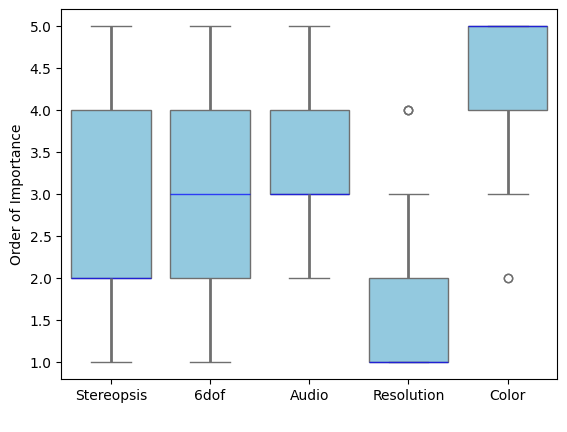

In [21]:

quest2= quest.copy()
quest2.columns = ["index", "id","stereopsis","6dof", "audio","resolution", "color"]

#order used in the data analysis:
mycols = ["stereopsis","6dof", "audio","resolution", "color"]
tmp= pd.concat(map(quest2.get, mycols))

q3 = pd.DataFrame(tmp, columns=["Order of Importance"])


al = ["Stereopsis" for x in range(26)]
bl = ["6dof" for x in range(26)]
cl = ["Audio" for x in range(26)]
dl = ["Resolution" for x in range(26)] 
el = ["Color" for x in range(26)]
#Notice: both of previous options display the same result, just in a different order

ll = al +bl + cl+ dl+ el
q3[" "] = ll

#pal = "Set2";
sigma = .05;



ax=sb.boxplot( x =  " ", y = "Order of Importance", data = q3, showcaps = True, boxprops = { },showfliers=True, whiskerprops = {'linewidth':2, "zorder":10}, medianprops=dict(color="blue", alpha=0.7), orient = "v",color='skyblue')

if WRITE_DATA:
    #we save the figure:    
    plt.savefig("questionnaire_boxplot.png", dpi=png_res,
        transparent=True,
        bbox_inches='tight', pad_inches=0.02)



 

In [22]:
#we create:
RLscore_per_subject = pd.DataFrame(np.zeros((32,nparticipants)))

for s in range(nparticipants):
    temp = np.zeros((32,32))
    last_iteration = last_iterations[s]
    temp = get_qvals_matrix(s, last_iteration-1)
    rl_score_1subj = np.sum(temp, 1)
    #display(rl_score_1subj)
    RLscore_per_subject[s]= rl_score_1subj
    
#RLscore_per_subject
print("there is not enough RL data per subject to compare with individual responses per subject")

there is not enough RL data per subject to compare with individual responses per subject


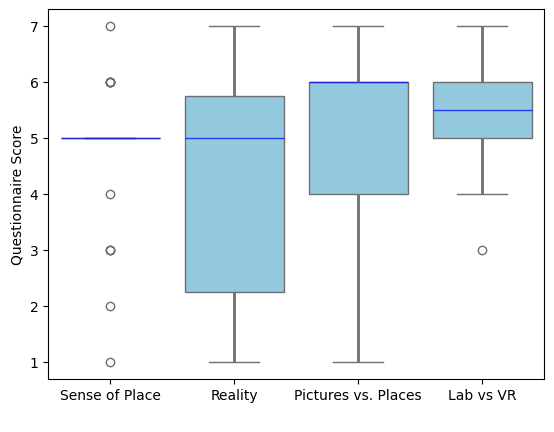

In [23]:
quest3 = subj_quest[["id","sensacion.lugar","reality", "pictures_places","lab_vr"]]

mycols = ["sensacion.lugar","reality", "pictures_places","lab_vr"]
tmp= pd.concat(map(quest3.get, mycols))

q4 = pd.DataFrame(tmp, columns=["Questionnaire Score"])


al = ["Sense of Place" for x in range(26)]
bl = ["Reality" for x in range(26)]
cl = ["Pictures vs. Places" for x in range(26)]
dl = ["Lab vs VR" for x in range(26)] 

#Notice: both of previous options display the same result, just in a different order

ll = al +bl + cl+ dl
q4[" "] = ll

#pal = "Set2";
sigma = .05;

#print("Figure 5:")
ax=sb.boxplot( x =  " ", y = "Questionnaire Score", data = q4, showcaps = True, boxprops = { },showfliers=True, whiskerprops = {'linewidth':2, "zorder":10}, medianprops=dict(color="blue", alpha=0.7), orient = "v",color='skyblue')

if WRITE_DATA:
    #we save the figure:    
    plt.savefig("questionnaire2_boxplot.png", dpi=png_res,
        transparent=True,
        bbox_inches='tight', pad_inches=0.02)

In [24]:
#import random

#import scipy
#participant_sample = 26
#number_iterations = 10000
 
#display("samples of "+ str(participant_sample) + " participants,"
#    "we are calculating:" +
#        str(number_iterations)+ 
#        " combinations of a total of :" 
#        +str (scipy.special.binom(nparticipants, participant_sample)))
    
     
#RLscore_per_iteration = pd.DataFrame(np.zeros((32,number_iterations)))


#for it in range(number_iterations):

#    #we pick a random subset of participants of size number_participants
#    l=list(range(nparticipants))
    
#    random.shuffle(l)#with this commented all columns must look the same
#    part_subset = l[0:participant_sample]

    
#   #we want to compare these with the preferences of the participants:      
#    sampled_qvals = RLscore_per_subject[part_subset]
#    #sampled_qvals.columns = ['RL_score']
#    rl_score_1col = np.sum(sampled_qvals, 1)
#    RLscore_per_iteration[it] = rl_score_1col;
    
    
#display(RLscore_per_iteration)
#if WRITE_DATA:
#    with open('rl_score_per_iteration.csv', 'w') as myfile:
#        myfile.write(RLscore_per_iteration.to_csv())

## 3. Demographic data

We generate tables and figures to show the demographics data

In [25]:

demo_data = []


#we  read the demographics:
subj_demographics = subj_quest.copy()
#subj_demographics = subj_demographics.loc[subj_demographics["id"].isin(selectedParticipants)]

#Creating a new dataframe from the subj_quest, just including preferences
quest_dem = subj_demographics[["id","gender", "age",
                               "expertise_1",
                               "expertise_2",
                               "expertise_3" ]]

quest_dem.columns =["ID","gender","age","vr-programming","vr-designing","VR-experiences"]

# quest_dem['gender'] = quest_dem['gender'].astype('str')
# quest_dem["gender"] = quest_dem["gender"].replace("1","F")
# quest_dem["gender"] = quest_dem["gender"].replace("0","M")



quest_dem= quest_dem.reset_index()

display(quest_dem)

print("gender: 1 is female, 0 is male")
quest_dem['gender'].value_counts()


#display(len(selectedParticipants))

,index,ID,gender,age,vr-programming,vr-designing,VR-experiences
0,1,101,0,35-44,1,1,1
1,2,102,1,18-24,1,1,1
2,3,103,1,18-24,1,1,1
3,4,104,0,35-44,1,1,1
4,5,105,1,25-34,1,1,1
5,6,106,0,18-24,1,1,1
6,8,108,1,18-24,1,1,1
7,9,109,0,25-34,1,1,2
8,10,110,1,25-34,1,1,2
9,11,111,0,25-34,5,5,5


gender: 1 is female, 0 is male


gender
1    15
0    11
Name: count, dtype: int64

## 4. Formatting for Statistical data analysis

When there is a sequence of configurations like:

10110
10110

We don't know which one was proposed and rejected.
On the opposite, in a sequence like:
11110
11111
we know that the last one was proposed and accepted.

To know both - what was proposed and what was accepted / rejected, we output like this:

initial configuration, then 1,1, 3,0, 2,1, 4,1, 5, 0 ...

The first number is 1 to 5 indicating which change was proposed. The second number is whether it was accepted or not.
1 = stereopsis, 5 = colour.

For example: if the initial configuration were 00000, then this would lead to the sequence:

10000
10000
11000
11010
11010

Then end each sequence ends with a 9.
The very first number could be in the range 1 to 32 which corresponds to the configuration, then the sequence as above. So the above would be 

32,1,1,3,0,2,1,4,1,5,0,9

assuming that they stopped after the 5th proposal.

**Note:** to understand the explanation, in the configurations listed in binary format  the weights of the config are in reverse to what is assumed in the script




In [26]:
#desired values:      ["stereopsis"=1,"6dof"=2, "audio"=3,"resolution"=4, "color"=5]

## in the presented matrix, the values are considered in binary. This means that the columns in pmat are consistent with weights in the binary value (right to left), not the column (left to right).  Therefore:
config_codes= [5,4,3,2,1]

#this can also be seen when we calculate the config value:
#    val = temp["stereopsis"]*16 + temp["6dof"]*8 + temp["audio"]*4 + temp["resolution"]*2 + temp["color"]*1


In [27]:
def get_first_array_piece(index_participant):
    iteration = 0
    result = []
    p = participant_data[index_participant]
    presentedmat = p[iteration]["infoPres"]
    
    acceptedmat = p[iteration]["infoAccepted"]
    s=(32,5)
    pmat = np.reshape(np.asarray(presentedmat),s)
   
    amat = np.reshape(np.asarray(acceptedmat),s)
    for j in range(5):
        for i in range(32):
            if(pmat[i,j] != 0):
                result.append(config_codes[j]) #we want values 1 to 5, we get values 0 to 4
                result.append(int(amat[i,j]))
    return result   



In [28]:
def get_notfirst_array_piece(index_participant, iteration):
    result = []
    p = participant_data[index_participant]
    presentedmat          = p[iteration]["infoPres"]
    previous_presentedmat = p[iteration-1]["infoPres"]
    acceptedmat           = p[iteration]["infoAccepted"]
    previous_acceptedmat  = p[iteration-1]["infoAccepted"]
    s=(32,5)
    pmat      = np.reshape(np.asarray(presentedmat),s)
    prev_pmat = np.reshape(np.asarray(previous_presentedmat),s)
    amat      = np.reshape(np.asarray(acceptedmat),s)
    prev_amat = np.reshape(np.asarray(previous_acceptedmat),s)

    for j in range(5):
        for i in range(32):
            if(pmat[i,j] > prev_pmat[i,j]):
                #print([i,j])
                #print(pmat[i,j])
                #print(prev_pmat[i,j])
                #print(amat[i,j])
                #print(prev_amat[i,j])
                result.append(config_codes[j]) #we want values 1 to 5, we get values 0 to 4
                if(amat[i,j] != prev_amat[i,j]):
                    result.append(1)
                else: 
                    result.append(0)
    return result   




In [29]:
last_iterations

nparticipants=len(participant_data)

outcome_shape = (nparticipants, max(last_iterations)*2 + 2)
outcome_table = -1 * np.ones(outcome_shape,dtype=int)

for p in range(nparticipants):
    participant_row = []
    init_config_in_binary = participant_data[p][0]['currentstate']
    participant_row = participant_row +  [int(init_config_in_binary,2)]
    participant_row  = participant_row  +  get_first_array_piece(p) # the operation + concatenates arrays
    for i in range(1,last_iterations[p]):
        participant_row = participant_row + ( get_notfirst_array_piece(p, i) )
    participant_row = participant_row + [9]
    outcome_table[p][0:len(participant_row)] = participant_row [0:len(participant_row)]

outcome_table

#with open('Data4StatisticalModel.csv', 'w') as myfile:
#        myfile.write(pd.DataFrame(outcome_table).to_csv())

with open('results-transitions.csv', 'w') as myfile:
        myfile.write(pd.DataFrame(outcome_table).to_csv(index=False,header=False))



**Some extra tests to confirm the previous part does output what we want**

In [30]:
check = get_notfirst_array_piece(2,1)
check

[5, 1]

In [31]:
print("check to verify problem with order of matrix")
test_participant =2

check = get_first_array_piece(test_participant)
print(check)


test_iteration =0
showp = participant_data[test_participant]
showpresentedmat = showp[test_iteration]["infoPres"]
s=(32,5)
showpmat = np.reshape(np.asarray(showpresentedmat),s)
print(showpmat)
print("notice the value 1 works as if we counted columns in the reversed order")

#inbin = format (4, "5b")
#print(inbin)
#print(inbin[3])

check to verify problem with order of matrix
[2, 1]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
notice the value 1 works as if we counted columns in the reversed order


In [32]:
print("In the previous, the column codes are :      stereopsis,6dof,audio, resolution, color")
print("Notice that when checking the configuration visits in binary, the weight of each factor is the reverse of the column number. \nSo, when subj=0 and config= 0 the cell [config,subj], with value 10110, the 0 corresponds to stereopsis, not color ")
print("If this is NOT TRUE, then we should reverse the order of the values in the array config_codes ")


print(Configuration_visits)

In the previous, the column codes are :      stereopsis,6dof,audio, resolution, color
Notice that when checking the configuration visits in binary, the weight of each factor is the reverse of the column number. 
So, when subj=0 and config= 0 the cell [config,subj], with value 10110, the 0 corresponds to stereopsis, not color 
If this is NOT TRUE, then we should reverse the order of the values in the array config_codes 
      0     1     2     3    4     5     6     7     8     9     10    11  \
0   22.0  10.0   5.0   1.0  5.0  28.0  15.0  10.0  20.0  13.0  31.0   9.0   
1   22.0  10.0  13.0   5.0  5.0  28.0  15.0  14.0  22.0  13.0  23.0   9.0   
2   22.0  10.0  12.0   5.0  5.0  29.0  14.0  15.0  22.0  15.0  22.0   9.0   
3   22.0  14.0   4.0   4.0  5.0  31.0  14.0  15.0  22.0  15.0  22.0  13.0   
4   22.0  14.0   5.0  12.0  5.0  31.0  15.0  15.0  22.0  15.0  22.0  12.0   
5   22.0  14.0  13.0  12.0  5.0  31.0  15.0  15.0  22.0  15.0  22.0  12.0   
6   22.0  14.0  13.0  14.0  5.0  31.0 